In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import paper_classes_2 as pc
import Post_processing as pp
import itertools
import os
import import_ipynb
import comm_as_today_run as comm
import pickle
from functools import wraps
import time


# First let's load the Swiss community with 100 houses from the CREM dataset

if it is the first time you run this script set first_time to True (to select randomly the demand profiles and the PV sizes), otherwise set it to False

In [7]:
def fn_timer(function):
    @wraps(function)
    def function_timer(*args, **kwargs):
        t0 = time.time()
        result = function(*args, **kwargs)
        t1 = time.time()
        print ("Total time running %s: %s seconds" %
               (function.__name__, str(t1-t0))
               )
        return result
    return function_timer

In [23]:
def sell_prob(SOC,price,Capacity,flag_sp,path):
    '''
    Description
    -----------
    This function returns the selling probability based on the SOC, price, capacity and case. As well as the results of the survey which are stored as .txt
    Parameters
    ------
    SOC: float; Battery state of charge at time t
    price: float; Electricity price at time t
    Capacity: float; Battery capacity
    case: string; either PV or batt from where the user is willing to sale
    path: string; path where the .txt are found
    ------
    out: int; Either 1 or 0 if sell or not
    TODO
    ------
    '''
    #define the matrix of probs
    if flag_sp==2:
        prob_mat=pd.read_table(path+'Input/P_selling_by_price_and_autarky2.txt',sep='\t',index_col=[0])
        #prob_mat=pd.read_table(path+'Input/surplus_cluster1_p_selling.txt',sep='\t',index_col=[0])
        #prob_mat=pd.read_table(path+'Input/surplus_cluster2_p_selling.txt',sep='\t',index_col=[0])
    elif flag_sp==1:#when selling from battery day
        prob_mat=pd.read_table(path+'Input/P_selling_by_price_and_autarky_2.txt',sep='\t',index_col=[0])
        #prob_mat=pd.read_table(path+'Input/nosurplus_cluster1_p_selling.txt',sep='\t',index_col=[0])
        #prob_mat=pd.read_table(path+'Input/nosurplus_cluster2_p_selling.txt',sep='\t',index_col=[0])
    elif flag_sp==3:#when selling from battery night
        prob_mat=pd.read_table(path+'Input/P_selling_by_price_and_autarky_2.txt',sep='\t',index_col=[0])
        #prob_mat=pd.read_table(path+'Input/nosurplus_cluster1_p_selling.txt',sep='\t',index_col=[0])
        #prob_mat=pd.read_table(path+'Input/nosurplus_cluster2_p_selling.txt',sep='\t',index_col=[0])
    
    if SOC==0:
        out=0
    else:
        I=np.array([0,0.05,0.2,0.35,0.5,0.65,0.8,0.95,1.0001])#define the interval of SOC
        ind=find_interval(SOC,I*Capacity)
        if ind==-1:
            prob=prob_mat.loc[1,str(price)]
        else:
            prob=prob_mat.loc[I[ind],str(price)]
        out=np.random.choice(2,1,p=[1-prob,prob]) 
    return out

In [18]:

def find_interval_PQ(x, partition):
    '''
    Description
    -----------
    find_interval at which x belongs inside partition. Returns the index i.

    Parameters
    ------
    x: float; numerical value
    partition: array; sequence of numerical values
    Returns
    ------
    i: index; index for which applies
    partition[i] < x < partition[i+1], if such an index exists.
    -1 otherwise
    TODO
    ------
    '''
    
    for i in range(0, len(partition)):
        #print(partition)
        if x<partition[1]:
            return 1
        elif x < partition[i]:
            return i-1
        
    return -1

In [24]:
def find_interval(x, partition):
    '''
    Description
    -----------
    find_interval at which x belongs inside partition. Returns the index i.

    Parameters
    ------
    x: float; numerical value
    partition: array; sequence of numerical values
    Returns
    ------
    i: index; index for which applies
    partition[i] < x < partition[i+1], if such an index exists.
    -1 otherwise
    TODO
    ------
    '''

    for i in range(0, len(partition)):
        if x < partition[i]:
            return i-1
    return -1



In [11]:
@fn_timer
def get_surplus_hour(res_pv):
#Get the first surplus hour
    sp_hour=[]
    if int(res_pv.shape[0]/365)==24:
        aux_res_pv=np.array(res_pv).reshape((365,24))
    else:
        print('TODO')
        
        
    for day in range(0,365):
        sp_hour.append(np.argmax(aux_res_pv.reshape((365,24))[day]>0))
    return sp_hour

In [45]:
@fn_timer
def dispatch_probs(pv, demand, param, return_series=False):
    """ Self consumption maximization pv + battery dispatch algorithm.
    The dispatch of the storage capacity is performed in such a way to maximize self-consumption:
    the battery is charged when the PV power is higher than the load and as long as it is not fully charged.
    It is discharged as soon as the PV power is lower than the load and as long as it is not fully discharged.
    Arguments:
        pv (pd.Series): Vector of PV generation, in kW DC (i.e. before the inverter)
        demand (pd.Series): Vector of household consumption, kW
        param (dict): Dictionary with the simulation parameters:
                timestep (float): Simulation time step (in hours)
                BatteryCapacity: Available battery capacity (i.e. only the the available DOD), kWh
                BatteryEfficiency: Battery round-trip efficiency, -
                InverterEfficiency: Inverter efficiency, -
                MaxPower: Maximum battery charging or discharging powers (assumed to be equal), kW
        return_series(bool): if True then the return will be a dictionary of series. Otherwise it will be a dictionary of ndarrays.
                        It is reccommended to return ndarrays if speed is an issue (e.g. for batch runs).
    Returns:
        dict: Dictionary of Time series
    """
    
        
    path=os.getcwd()+'/Switzerland/'
    kW_dis= param['kW_dis']
    bat_size_e_adj = param['BatteryCapacity']
    bat_size_p_adj = param['MaxPower']
    n_bat = param['BatteryEfficiency']
    n_inv = param['InverterEfficiency']
    timestep = param['timestep']
    # We work with np.ndarrays as they are much faster than pd.Series
    Nsteps = len(pv)
    LevelOfCharge = np.zeros(Nsteps)
    pv2store = np.zeros(Nsteps)
    inv2grid = np.zeros(Nsteps)
    store2inv = np.zeros(Nsteps)
    store2load = np.zeros(Nsteps)
    grid2store = np.zeros(Nsteps) # TODO Always zero for now.
    store2grid = np.zeros(Nsteps)
    batt_losses = np.zeros(Nsteps)
    prices = np.array(param['df_prices']).flatten()
    #prices=np.ones(Nsteps)*.07
    #Load served by PV
    pv2inv = np.minimum(pv, demand / n_inv)  # DC direct self-consumption

    #Residual load
    res_load = (demand - pv2inv * n_inv)  # AC
    inv2load = pv2inv * n_inv  # AC

    #Excess PV
    res_pv = np.maximum(pv - demand/n_inv, 0)  # DC
    #PV to storage after eff losses
    pv2inv = pv2inv.values

    #first timestep = 0
    LevelOfCharge[0] = 0  # bat_size_e_adj / 2  # DC
    ######################################
    
    if (bat_size_e_adj!=0)&(pv.sum()>0):
        sp_hour=get_surplus_hour(res_pv)
        for i in range(1,Nsteps):
            ######################################
            if sp_hour[int(np.floor((i)/24))]==0:#no surplus at all
                flag_sp=3
            elif i%24<sp_hour[int(np.floor((i)/24))]-2:#2h bf surplus
                flag_sp=1
            elif i%24>sp_hour[int(np.floor((i)/24))]-14+24: #14h bf surplus
                flag_sp=3
            else:#while sp
                flag_sp=2
            ######################################
            #PV to storage
            if (sell_prob(LevelOfCharge[i-1],prices[i],bat_size_e_adj,flag_sp,path)&(flag_sp==2)):
                aux=res_pv[i]-min(kW_dis/n_inv/timestep,res_pv[i])
                pv2inv[i]=pv2inv[i]+aux
                res_pv[i]=res_pv[i]-aux
                inv2grid[i]=aux#DC



            if LevelOfCharge[i-1] >= bat_size_e_adj:  # if battery is full
                    pv2store[i] = 0
            else: #if battery is not full
                if LevelOfCharge[i-1] + res_pv[i] * timestep > bat_size_e_adj:  # if battery will be full after putting excess
                    pv2store[i] = min((bat_size_e_adj - LevelOfCharge[i-1]) / timestep, bat_size_p_adj)
                else:
                    pv2store[i] = min(res_pv[i], bat_size_p_adj)

            #Storage to load or grid
            ######################################
            batt_losses[i]=pv2store[i]*(1-n_bat)
            if pv2store[i]==0:#not charging
                store2load[i] = min(bat_size_p_adj,  # DC
                               res_load[i] / n_inv,
                               LevelOfCharge[i-1] / timestep)
                if (sell_prob(LevelOfCharge[i-1]-store2load[i],prices[i],bat_size_e_adj,flag_sp,path)&(flag_sp!=2)):
                    store2grid[i] = min(bat_size_p_adj-store2load[i]/timestep,  # DC
                                       kW_dis / n_inv/timestep/n_bat,
                                       (LevelOfCharge[i-1]-store2load[i]) / timestep)
                    store2inv[i] = (store2load[i]+store2grid[i])
                else:
                    store2inv[i]=store2load[i]
            ######################################a

            #SOC
            LevelOfCharge[i] = min(LevelOfCharge[i-1] - batt_losses[i]-(store2inv[i] - pv2store[i] - grid2store[i]) * timestep,  # DC
                                   bat_size_e_adj)

    store2grid=store2grid # AC
    pv2inv = pv2inv + res_pv - pv2store
    inv2load = inv2load + store2load * n_inv  # AC
    inv2grid = (inv2grid+res_pv - pv2store+store2grid) * n_inv  # AC
    grid2load = demand - inv2load  # AC
    inv_losses=(pv2inv+store2inv)*(1-n_inv)

    #MaxDischarge = np.minimum(LevelOfCharge[i-1]*BatteryEfficiency/timestep,MaxPower)


    #Potential Grid to storage  # TODO: not an option for now in this strategy
    # GridPurchase = False

    out = {'pv2inv': pv2inv,
            'res_pv': res_pv,
            'pv2store': pv2store,
            'inv2load': inv2load,
            'grid2load': grid2load,
            'store2inv': store2inv,
            'LevelOfCharge': LevelOfCharge,
            'inv2grid': inv2grid,
            'store2grid':store2grid,
            'store2load':store2load,
            'batt_losses':batt_losses,
            'inv_losses':inv_losses
            # 'grid2store': grid2store
            }
    if not return_series:
        out_pd = {}
        for k, v in out.items():  # Create dictionary of pandas series with same index as the input pv
            out_pd[k] = pd.Series(v, index=pv.index)
        out = out_pd
    return out

In [13]:
@fn_timer
def price_probability(df_CH,selection,inputs,pv_penetration,batt_penetration):
    '''
    Description
    -----------
    Define the price structure according to the inputs (how the community is created), the choice of the probability, 
    whether it is for the 50% or other probability according to the psychology data, the amount of kWh that will be 
    discharged every time a decision is made (1 or 2 kWh are the "normal" options) and the case, whether it is the
    price created from the probability of selling from PV or the battery in the morning or the evening.
    
    Parameters
    ------
    inputs:        dict; Dictionary that includes prob_choice (choice of the probability to create the prices 50% or other),
                    prices, kWh_dis (amount of energy to be discharged at every time a decision is made),  
                    case (included in ['PV', 'Batt'] the price may be created from the probability of selling from PV or the battery

    Return
    ------
    inputs: dict; Input dictionary updated with prices

    TODO
    ------

    '''
    list_names=[str(name) for name in selection.name]
    # Get the total demand
    sum_demand=df_CH.loc[:,list_names].sum(axis=1)
    # Get total PV generation
    aux=pd.DataFrame()
    sum_PV=pd.DataFrame()
    for i in range(len(selection)):
        aux=df_CH.E_PV*selection.loc[:,['PV_size','sub_'+str(pv_penetration)+'_'+str(batt_penetration)]].product(axis=1)[i]
        if i==0:
            sum_PV=aux
        else:
            sum_PV=aux+sum_PV

    net_demand=sum_demand-sum_PV
    prob_mat_PV=pd.read_csv('Switzerland/Input/P_selling_by_price_and_autarky2.txt',sep='\t',index_col=[0])
    prob_mat_Batt=pd.read_csv('Switzerland/Input/P_selling_by_price_and_autarky_2.txt',sep='\t',index_col=[0])
    sp_hour=get_surplus_hour(sum_PV-sum_demand)
    if len(inputs['prob_choice'])==1:
        q_supply_midday=int(np.floor(inputs['PV_penetration']*inputs['Batt_penetration']*inputs['community_size']))*prob_mat_PV.loc[inputs['prob_choice'][0],:]*inputs['kW_dis']
        q_supply_other=int(np.floor(inputs['PV_penetration']*inputs['Batt_penetration']*inputs['community_size']))*prob_mat_Batt.loc[inputs['prob_choice'][0],:]*inputs['kW_dis']
        df_prices=pd.DataFrame(index=net_demand.index)
        df_prices.loc[:,'prices']=net_demand.apply(lambda x:inputs['prices'][find_interval_PQ(x,q_supply_midday)])
        df_prices.loc[(df_prices.index.hour<sp_hour[int(np.floor((i)/24))]-2)|(df_prices.index.hour>sp_hour[int(np.floor((i)/24))]-14+24),'prices']=net_demand[(net_demand.index.hour<sp_hour[int(np.floor((i)/24))]-2)|(net_demand.index.hour>sp_hour[int(np.floor((i)/24))]-14+24)].apply(lambda x:inputs['prices'][find_interval_PQ(x,q_supply_other)])
        inputs.update({'df_prices':df_prices})
        return inputs
    elif len(inputs['prob_choice'])==3:
        q_supply_morning=int(np.floor(inputs['PV_penetration']*inputs['Batt_penetration']*inputs['community_size']))*prob_mat_Batt.loc[inputs['prob_choice'][0],:]*inputs['kW_dis']
        q_supply_midday=int(np.floor(inputs['PV_penetration']*inputs['Batt_penetration']*inputs['community_size']))*prob_mat_PV.loc[inputs['prob_choice'][1],:]*inputs['kW_dis']
        q_supply_evening=int(np.floor(inputs['PV_penetration']*inputs['Batt_penetration']*inputs['community_size']))*prob_mat_Batt.loc[inputs['prob_choice'][2],:]*inputs['kW_dis']
        df_prices=pd.DataFrame(index=net_demand.index)
        df_prices.loc[:,'prices']=net_demand.apply(lambda x:inputs['prices'][find_interval_PQ(x,q_supply_midday)])
        df_prices.loc[(df_prices.index.hour<sp_hour[int(np.floor((i)/24))]-2),'prices']=net_demand[net_demand.index.hour<sp_hour[int(np.floor((i)/24))]-2].apply(lambda x:inputs['prices'][find_interval_PQ(x,q_supply_morning)])
        df_prices.loc[df_prices.index.hour>sp_hour[int(np.floor((i)/24))]-14+24,'prices']=net_demand[net_demand.index.hour>sp_hour[int(np.floor((i)/24))]-14+24].apply(lambda x:inputs['prices'][find_interval_PQ(x,q_supply_evening)])

        inputs.update({'df_prices':df_prices})
        return inputs
    else:
        print('Warning: this function only takes either one choice of probability for the whole day or three separated for morning, midday and evening')
        return

In [14]:
@fn_timer
def run_comm_p2p(first_time):
    community_size=100
    timestep=1 # in hours
    
    list_pv_penetration=[100,75,50,25]# %
    list_batt_penetration=[100,75,50,25]# %
    for pv_penetration in list_pv_penetration:
        for batt_penetration in list_batt_penetration:
            print('########################################')
            print('PV penetration {}'.format(pv_penetration))

            print('Battery penetration {}'.format(batt_penetration))
            if first_time:
                out_comm_final=comm.load_obj('community_as_today'+'_'+str(pv_penetration)+'_'+str(batt_penetration))
            param_tech=out_comm_final['param_tech']
            param_tech.update({'kW_dis':1})

            df_CH=out_comm_final['df']
            selection=out_comm_final['selection']

            param_tech.update({'kW_dis':1,'PV_penetration':pv_penetration/100,'Batt_penetration':batt_penetration/100,'prob_choice':[0.35,0.5,.95],
                        'prices':np.array([0, 0.07,.10,.13,.16,.19,.22,.25,.28]),'community_size':community_size})
            price_probability(df_CH,selection,param_tech,pv_penetration,batt_penetration)

            # We set the battery capacity to zero in some cases to get the direct SC only
            # We iterate through the community and get the dispatching
            param_tech_no_batt=param_tech.copy()
            param_tech_no_batt.update({'BatteryCapacity':0,'MaxPower':0})


            nested_out={}
            j=0
            k=0
            PV_size_comm=0
            for i in selection.index:
                print(i, end='')
                if selection.loc[i,'sub_'+str(out_comm_final['pv_penetration'])+'_100']:#all with PV
                    PV_size_comm+=selection.PV_size[i]
                    if selection.loc[i,'sub_'+str(out_comm_final['pv_penetration'])+'_'+str(out_comm_final['batt_penetration'])]: #if battery
                        nested_out[i]=dispatch_probs(df_CH.E_PV*selection.PV_size[i],df_CH.loc[:,str(selection.name[i])],param_tech)
                        j+=1
                    else: #if only PV battery=0 kWh
                        nested_out[i]=dispatch_probs(df_CH.E_PV*selection.PV_size[i],df_CH.loc[:,str(selection.name[i])],param_tech_no_batt)
                        k+=1
                else: #No PV
                    nested_out[i]=dispatch_probs(df_CH.E_PV*0,df_CH.loc[:,str(selection.name[i])],param_tech_no_batt)
            #get all the data in a single dict
            pv2inv=pd.DataFrame()
            res_pv=pd.DataFrame()
            pv2store=pd.DataFrame()
            inv2load=pd.DataFrame()
            grid2load=pd.DataFrame()
            store2inv=pd.DataFrame()
            LevelOfCharge=pd.DataFrame()
            inv2grid=pd.DataFrame()
            for i in nested_out.keys():
                pv2inv['pv2inv'+str(i)]=nested_out[i]['pv2inv']
                pv2store['pv2store'+str(i)]=nested_out[i]['pv2store']
                inv2load['inv2load'+str(i)]=nested_out[i]['inv2load']
                store2inv['store2inv'+str(i)]=nested_out[i]['store2inv']
                LevelOfCharge['LevelOfCharge'+str(i)]=nested_out[i]['LevelOfCharge']
                res_pv['res_pv'+str(i)]=nested_out[i]['res_pv']#not important, recalculated later
                inv2grid['inv2grid'+str(i)]=nested_out[i]['inv2grid']#not important, recalculated later
                grid2load['grid2load'+str(i)]=nested_out[i]['grid2load']#not important, recalculated later
            nested_dict={'pv2inv':pv2inv.sum(axis=1),'res_pv':res_pv.sum(axis=1),'pv2store':pv2store.sum(axis=1),'inv2load':inv2load.sum(axis=1),
                         'grid2load':grid2load.sum(axis=1),'store2inv':store2inv.sum(axis=1),'LevelOfCharge':LevelOfCharge.sum(axis=1),'inv2grid':inv2grid.sum(axis=1)}

            param_tech_no_batt.update({'InverterEfficiency':1})#nested_dict['inv2grid'] is PV generation already in AC used as input for next step
            out_comm_res=dispatch_probs(nested_dict['inv2grid'],nested_dict['grid2load'],param_tech_no_batt)
            out_comm_final={}
            out_comm_final['pv2inv']=nested_dict['pv2inv']
            out_comm_final['pv2store']=nested_dict['pv2store']
            out_comm_final['inv2load']=(nested_dict['inv2load']+out_comm_res['inv2load'])
            out_comm_final['store2inv']=nested_dict['store2inv']
            out_comm_final['LevelOfCharge']=nested_dict['LevelOfCharge']
            out_comm_final['res_pv']=out_comm_res['res_pv']
            out_comm_final['inv2grid']=out_comm_res['inv2grid']
            out_comm_final['grid2load']=out_comm_res['grid2load']
            out_comm_final['batt_losses']=nested_dict['batt_losses']
            out_comm_final['inv_losses']=nested_dict['inv_losses']

            out_comm_final['PV_size_comm']=PV_size_comm
            out_comm_final['df']=df_CH
            out_comm_final['param_tech']=param_tech
            out_comm_final['param_tech_no_batt']=param_tech_no_batt
            out_comm_final['nested_dict']=nested_dict
            out_comm_final['pv_penetration']=pv_penetration
            out_comm_final['batt_penetration']=batt_penetration
            out_comm_final['selection']=selection

            
            print_analysis(df_CH.E_PV*PV_size_comm, df_CH.loc[:,list_names].sum(axis=1),param_tech_no_batt,out_comm_final)
            save_obj(out_comm_final,'community_p2p'+'_'+str(pv_penetration)+'_'+str(batt_penetration))
    return selection

In [ ]:
run_comm_p2p(True)

########################################
PV penetration 100
Battery penetration 100
Total time running get_surplus_hour: 0.0017390251159667969 seconds
Total time running price_probability: 0.8542871475219727 seconds
0Total time running get_surplus_hour: 0.0010766983032226562 seconds


/home/alejandropena/.conda/envs/alenv/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: read_table is deprecated, use read_csv instead.
/home/alejandropena/.conda/envs/alenv/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: read_table is deprecated, use read_csv instead.
/home/alejandropena/.conda/envs/alenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: read_table is deprecated, use read_csv instead.


Total time running dispatch_probs: 54.17626452445984 seconds
1Total time running get_surplus_hour: 0.0020651817321777344 seconds
Total time running dispatch_probs: 32.373897552490234 seconds
2Total time running get_surplus_hour: 0.0010638236999511719 seconds


In [19]:
community_size=100
timestep=1 # in hours
first_time=True
list_pv_penetration=[100,75,50,25]# %
list_batt_penetration=[100,75,50,25]# %
pv_penetration=50
batt_penetration=50
print('########################################')
print('PV penetration {}'.format(pv_penetration))

print('Battery penetration {}'.format(batt_penetration))
if first_time:
    out_comm_final=comm.load_obj('community_as_today'+'_'+str(pv_penetration)+'_'+str(batt_penetration))
param_tech=out_comm_final['param_tech']
param_tech.update({'kW_dis':1})

df_CH=out_comm_final['df']
selection=out_comm_final['selection']

param_tech.update({'kW_dis':1,'PV_penetration':pv_penetration/100,'Batt_penetration':batt_penetration/100,'prob_choice':[0.35,0.5,.95],
            'prices':np.array([0, 0.07,.10,.13,.16,.19,.22,.25,.28]),'community_size':community_size})
price_probability(df_CH,selection,param_tech,pv_penetration,batt_penetration)

# We set the battery capacity to zero in some cases to get the direct SC only
# We iterate through the community and get the dispatching
param_tech_no_batt=param_tech.copy()
param_tech_no_batt.update({'BatteryCapacity':0,'MaxPower':0})



########################################
PV penetration 50
Battery penetration 50
Total time running get_surplus_hour: 0.0010824203491210938 seconds
Total time running price_probability: 1.2619338035583496 seconds


In [49]:
out1=dispatch_probs(df_CH.E_PV*selection.PV_size[1],df_CH.loc[:,str(selection.name[1])],param_tech)

Total time running get_surplus_hour: 0.0028276443481445312 seconds


/home/alejandropena/.conda/envs/alenv/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: read_table is deprecated, use read_csv instead.
/home/alejandropena/.conda/envs/alenv/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: read_table is deprecated, use read_csv instead.
/home/alejandropena/.conda/envs/alenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: read_table is deprecated, use read_csv instead.


Total time running dispatch_probs: 30.5638267993927 seconds


In [50]:
comm.print_analysis(df_CH.E_PV*selection.PV_size[1],df_CH.loc[:,str(selection.name[1])],param_tech,out1)#probs

Total yearly consumption: 2713.44 kWh
Total PV production: 6301.76 kWh
Self Consumption: 2256.5 kWh
Total fed to the grid: 3419.78 kWh
Direct Self Consumption: 1056.32 kWh
Indirect Self Consumption: 1200.19 kWh
Total fed to the grid from PV: 2118.69 kWh
Total fed to the grid from battery: 1301.08 kWh
Total bought from the grid: 456.938 kWh
Self consumption rate (SCR): 35.8%
Self sufficiency rate (SSR): 83.2%
Amount of energy provided by the battery: 2660.92 kWh
Average Charging/Discharging depth: 0.72902
Number of equivalent full cycles per year: 266.092 
Total battery losses: 263.168 kWh
Total inverter losses: 362.316 kWh
Residue (check): -4.54747e-13 kWh


In [19]:
df2=pd.DataFrame([(df_CH.E_PV*selection.PV_size[1]),(df_CH.loc[:,str(selection.name[1])])]).T

In [39]:
df=pd.DataFrame(out1)

In [40]:
df.sum()

pv2inv           6301.761533
res_pv           5178.021448
pv2store            0.000000
inv2load         1056.315681
grid2load        1657.124319
store2inv           0.000000
LevelOfCharge       0.000000
inv2grid         4867.340161
store2grid          0.000000
store2load          0.000000
batt_losses         0.000000
inv_losses        378.105692
dtype: float64

In [21]:
df1=pd.concat([df,df2],axis=1)

In [22]:
# Energy balance

print('PV {:1g}'.format((df_CH.E_PV*selection.PV_size[1]).sum()))#PV

print('PV {:1g}'.format((df1.pv2inv+df1.pv2store).sum()))#PV

print('DC inv {:1g}'.format((df1.pv2inv+df1.store2inv).sum()))#DC inv

print('AC inv {:1g}'.format((df1.inv2grid+df1.inv2load).sum()))# AC inv

print('inv losses {:1g}'.format((df1.pv2inv+df1.store2inv).sum()*(1-.94)))#inv losses

print('batt losses {:1g}'.format((df1.pv2store-df1.store2grid-df1.store2load).sum()))#batt losses

print('pv2grid AC {:1g}'.format((df1.inv2grid-df1.store2grid*.94).sum()))#pv2grid AC

print('pv2load AC {:1g}'.format((df1.inv2load-df1.store2load*.94).sum()))#pv2load AC

print('balance pv2inv {:1g}'.format((df1.pv2inv*.94-(df1.inv2load-df1.store2load*.94)-(df1.inv2grid-df1.store2grid*.94)).sum()))

print('inv2grid store2grid {:1g}'.format((df1.inv2grid-df1.store2grid).sum()))

print('balance store {:1g}'.format((df1.store2inv-(df1.store2grid+df1.store2load)).sum()))

PV 4201.17
PV 4201.17
DC inv 3969.16
AC inv 3731.01
inv losses 238.15
batt losses 232.015
pv2grid AC 797.473
pv2load AC 736.174
balance pv2inv 2.71723e-15
inv2grid store2grid 708.101
balance store 0


/home/alejandropena/.conda/envs/alenv/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


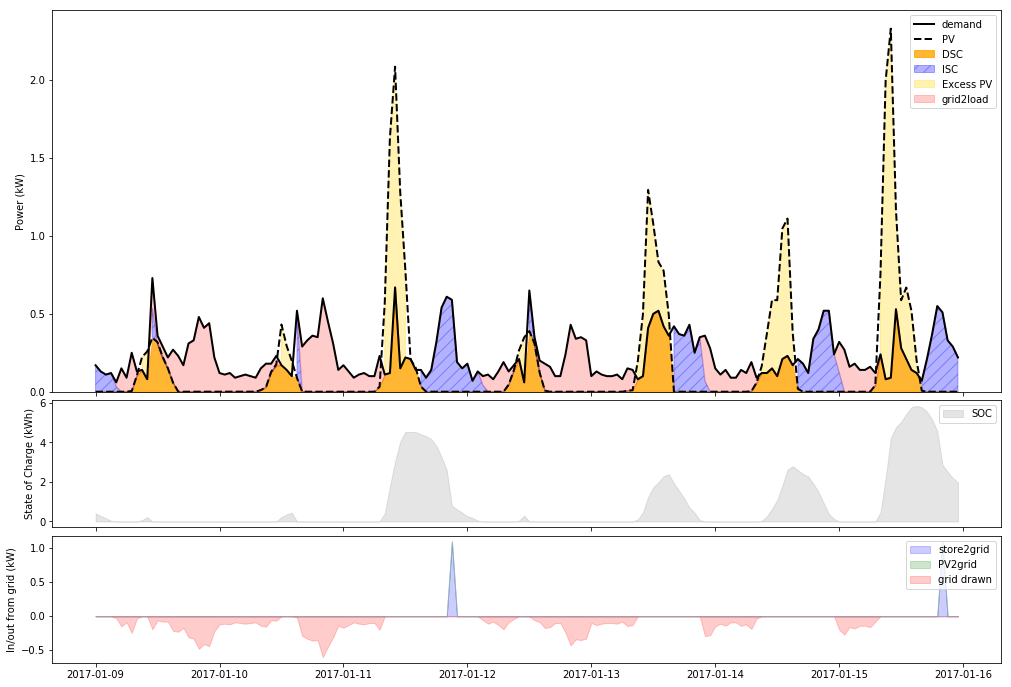

In [23]:
comm.plot_dispatch(df_CH.E_PV*selection.PV_size[1],df_CH.loc[:,str(selection.name[1])],out1,param_tech,week=2)

In [24]:
%%time
param_tech_no_batt=param_tech.copy()
param_tech_no_batt.update({'BatteryCapacity':0,'MaxPower':0})

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 13.1 µs


In [25]:
%%time
param_tech_no_batt=param_tech.copy()
param_tech_no_batt.update({'BatteryCapacity':0,'MaxPower':0})
nested_out={}
j=0
k=0
PV_size_comm=0
for i in selection.index:
    print(i, end='')
    if selection.loc[i,'sub_'+str(out_comm_final['pv_penetration'])+'_100']:#all with PV
        PV_size_comm+=selection.PV_size[i]
        if selection.loc[i,'sub_'+str(out_comm_final['pv_penetration'])+'_'+str(out_comm_final['batt_penetration'])]: #if battery
            nested_out[i]=dispatch_probs(df_CH.E_PV*selection.PV_size[i],df_CH.loc[:,str(selection.name[i])],param_tech)
            j+=1
        else: #if only PV battery=0 kWh
            nested_out[i]=dispatch_probs(df_CH.E_PV*selection.PV_size[i],df_CH.loc[:,str(selection.name[i])],param_tech_no_batt)
            k+=1
    else: #No PV
        nested_out[i]=dispatch_probs(df_CH.E_PV*0,df_CH.loc[:,str(selection.name[i])],param_tech_no_batt)
#get all the data in a single dict
pv2inv=pd.DataFrame()
res_pv=pd.DataFrame()
pv2store=pd.DataFrame()
inv2load=pd.DataFrame()
grid2load=pd.DataFrame()
store2inv=pd.DataFrame()
LevelOfCharge=pd.DataFrame()
inv2grid=pd.DataFrame()
for i in nested_out.keys():
    pv2inv['pv2inv'+str(i)]=nested_out[i]['pv2inv']
    pv2store['pv2store'+str(i)]=nested_out[i]['pv2store']
    inv2load['inv2load'+str(i)]=nested_out[i]['inv2load']
    store2inv['store2inv'+str(i)]=nested_out[i]['store2inv']
    LevelOfCharge['LevelOfCharge'+str(i)]=nested_out[i]['LevelOfCharge']
    res_pv['res_pv'+str(i)]=nested_out[i]['res_pv']#not important, recalculated later
    inv2grid['inv2grid'+str(i)]=nested_out[i]['inv2grid']#not important, recalculated later
    grid2load['grid2load'+str(i)]=nested_out[i]['grid2load']#not important, recalculated later
nested_dict={'pv2inv':pv2inv.sum(axis=1),'res_pv':res_pv.sum(axis=1),'pv2store':pv2store.sum(axis=1),'inv2load':inv2load.sum(axis=1),
             'grid2load':grid2load.sum(axis=1),'store2inv':store2inv.sum(axis=1),'LevelOfCharge':LevelOfCharge.sum(axis=1),'inv2grid':inv2grid.sum(axis=1)}
out_comm_res=dispatch_probs(nested_dict['inv2grid'],nested_dict['grid2load'],param_tech_no_batt)
out_comm_final={}
out_comm_final['pv2inv']=nested_dict['pv2inv']
out_comm_final['pv2store']=nested_dict['pv2store']
out_comm_final['inv2load']=(nested_dict['inv2load']+out_comm_res['inv2load'])
out_comm_final['store2inv']=nested_dict['store2inv']
out_comm_final['LevelOfCharge']=nested_dict['LevelOfCharge']
out_comm_final['res_pv']=out_comm_res['res_pv']
out_comm_final['inv2grid']=out_comm_res['inv2grid']
out_comm_final['grid2load']=out_comm_res['grid2load']
out_comm_final['battery_losses']=nested_dict['pv2store']-nested_dict['store2inv']
out_comm_final['inverter_losses']=(nested_dict['pv2inv']+nested_dict['pv2store']-out_comm_final['battery_losses']+out_comm_res['pv2inv']+out_comm_res['pv2store'])*(1-param_tech['InverterEfficiency'])
out_comm_final['PV_size_comm']=PV_size_comm
out_comm_final['df']=df_CH
out_comm_final['param_tech']=param_tech
out_comm_final['nested_dict']=nested_dict
out_comm_final['pv_penetration']=pv_penetration
out_comm_final['batt_penetration']=batt_penetration
out_comm_final['selection']=selection


0

/home/alejandropena/.conda/envs/alenv/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: read_table is deprecated, use read_csv instead.


1

/home/alejandropena/.conda/envs/alenv/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: read_table is deprecated, use read_csv instead.
/home/alejandropena/.conda/envs/alenv/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: read_table is deprecated, use read_csv instead.


23456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899CPU times: user 55min 4s, sys: 1min 4s, total: 56min 8s
Wall time: 56min 8s


In [26]:
#get all the data in a single dict
pv2inv=pd.DataFrame()
res_pv=pd.DataFrame()
pv2store=pd.DataFrame()
inv2load=pd.DataFrame()
grid2load=pd.DataFrame()
store2inv=pd.DataFrame()
LevelOfCharge=pd.DataFrame()
inv2grid=pd.DataFrame()
for i in nested_out.keys():
    pv2inv['pv2inv'+str(i)]=nested_out[i]['pv2inv']
    pv2store['pv2store'+str(i)]=nested_out[i]['pv2store']
    inv2load['inv2load'+str(i)]=nested_out[i]['inv2load']
    store2inv['store2inv'+str(i)]=nested_out[i]['store2inv']
    LevelOfCharge['LevelOfCharge'+str(i)]=nested_out[i]['LevelOfCharge']
    res_pv['res_pv'+str(i)]=nested_out[i]['res_pv']#not important, recalculated later
    inv2grid['inv2grid'+str(i)]=nested_out[i]['inv2grid']#not important, recalculated later
    grid2load['grid2load'+str(i)]=nested_out[i]['grid2load']#not important, recalculated later
nested_dict={'pv2inv':pv2inv.sum(axis=1),'res_pv':res_pv.sum(axis=1),'pv2store':pv2store.sum(axis=1),'inv2load':inv2load.sum(axis=1),
             'grid2load':grid2load.sum(axis=1),'store2inv':store2inv.sum(axis=1),'LevelOfCharge':LevelOfCharge.sum(axis=1),'inv2grid':inv2grid.sum(axis=1)}

Now calculate how the excess of PV will be absorbed in the remaining load of the community (all households without batteries)

In [27]:
out_comm_res=dispatch_probs(nested_dict['inv2grid'],nested_dict['grid2load'],param_tech_no_batt)

/home/alejandropena/.conda/envs/alenv/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: read_table is deprecated, use read_csv instead.
/home/alejandropena/.conda/envs/alenv/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: read_table is deprecated, use read_csv instead.
/home/alejandropena/.conda/envs/alenv/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: read_table is deprecated, use read_csv instead.


Finaly create the dictionary combining the results from the households with PV, PV and battery and without.

In [28]:
out_comm_final={}
out_comm_final['pv2inv']=nested_dict['pv2inv']
out_comm_final['pv2store']=nested_dict['pv2store']
out_comm_final['inv2load']=(nested_dict['inv2load']+out_comm_res['inv2load'])
out_comm_final['store2inv']=nested_dict['store2inv']
out_comm_final['LevelOfCharge']=nested_dict['LevelOfCharge']
out_comm_final['res_pv']=out_comm_res['res_pv']
out_comm_final['inv2grid']=out_comm_res['inv2grid']
out_comm_final['grid2load']=out_comm_res['grid2load']
out_comm_final['battery_losses']=nested_dict['pv2store']-nested_dict['store2inv']
out_comm_final['inverter_losses']=(nested_dict['pv2inv']+nested_dict['pv2store']-out_comm_final['battery_losses']+out_comm_res['pv2inv']+out_comm_res['pv2store'])*(1-param_tech['InverterEfficiency'])
out_comm_final['PV_size_comm']=PV_size_comm
out_comm_final['df']=df_CH
out_comm_final['param_tech']=param_tech
out_comm_final['nested_dict']=nested_dict
out_comm_final['pv_penetration']=pv_penetration
out_comm_final['batt_penetration']=batt_penetration
out_comm_final['selection']=selection


Run the analysis of the community with the PV size equals to the sum of all PV sizes and with the aggregated demand

In [29]:
list_names=[str(i) for i in selection.iloc[:,1]]

In [ ]:
comm.print_analysis(df_CH.E_PV*PV_size_comm, df_CH.loc[:,list_names].sum(axis=1),param_tech_no_batt,out_comm_final)

In [37]:
comm.print_analysis(df_CH.E_PV*PV_size_comm, df_CH.loc[:,list_names].sum(axis=1),param_tech_no_batt,out_comm_final)

Total yearly consumption: 285125 kWh
Total PV production: 372084 kWh
Self Consumption: 162746 kWh
Total fed to the grid: 165740 kWh
Total bought from the grid: 122379 kWh
Self consumption rate (SCR): 43.7%
Self sufficiency rate (SSR): 57.1%
Amount of energy provided by the battery: 60939.3 kWh
Average Charging/Discharging depth: inf
Number of equivalent full cycles per year: inf 
Total battery losses: 6047.16 kWh
Total inverter losses: 37550.3 kWh
Residue (check): 0 kWh


comm_as_today_run.ipynb:36: RuntimeWarning: divide by zero encountered in double_scalars
  "    \n",


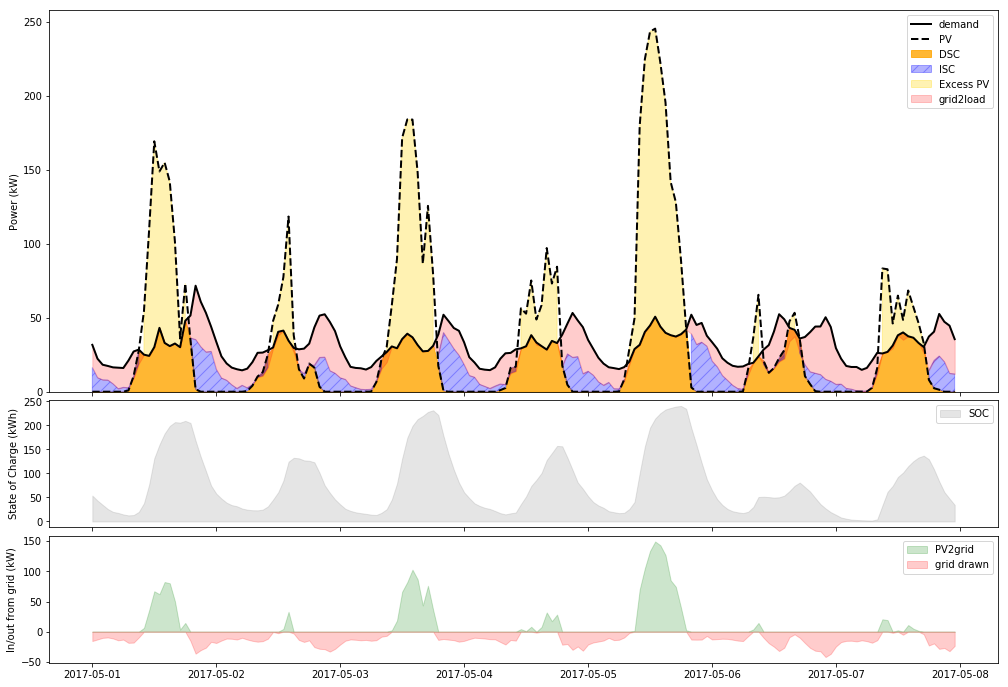

In [32]:
comm.plot_dispatch(df_CH.E_PV*PV_size_comm, df_CH.loc[:,list_names].sum(axis=1),out_comm_final,param_tech, week=18)

In [33]:
save_obj(out_comm_final,'community_p2p'+'_'+str(pv_penetration)+'_'+str(batt_penetration))

NameError: name 'save_obj' is not defined